In [27]:
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import List
import tsplib95
import numpy as np
import math
import matplotlib.pyplot as plt


In [84]:


def calculate_distance_matrix(values, calculate):
    size = len(values)
    matrix = np.zeros((size,size), dtype=np.uint32)
    
    for i, start in enumerate(values):
        #if i > 10:
        #    break
        for j, end in enumerate(values):
            #if j > 10:
            #    break
            matrix[i,j] = calculate(start, end, round=math.ceil)
    
    for i in range(size):
        matrix[i,i] = 2**32 -1
        
    return matrix



def plot_result(graph_cord, solution, filename=None, title="Title"):
    
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
    
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize = (8,8))
    plt.title(title, fontdict=font)    
    X = []
    Y = []
    labels = []
    
    for x, y, label in solution:
        X.append(x)
        Y.append(y)
        labels.append(label)
    

    ALL_Y = [node[1] for node in graph_cord]       
    ALL_X = [node[0] for node in graph_cord]

    #all cities  
    plt.scatter(ALL_X, ALL_Y)
    
    #solution path
    plt.plot(X, Y,"or-")
   
    #print labels
    for i in range(len(solution)):
        plt.text(X[i], Y[i], labels[i], fontsize=15)
    
    if filename:
        plt.savefig(filename)

    plt.show()

In [92]:

class Cycle():
    def __init__(self, vertex_list, length):
        self._vertex_list = vertex_list
        self._length = length
        
    @property
    def cycle(self):
        return self._vertex_list
    
    @property
    def length(self):
        return self._length
    
    def __str__(self):
        return f"({self._length}, {self._vertex_list})\n"
    
    def __repr__(self):
        return f"({self._length}, {self._vertex_list})\n"

In [147]:

class Instance():
    def __init__(self, strategy: Strategy, description="") -> None:
        self._strategy = strategy
        self._coordinates = []
        self._labels = []
        self._solutions = []
        self._description = description
        self._distance_matrix = None
    
    
    @property
    def description(self):
        return self._description
    
    @description.setter
    def description(self, description):
        self._description = description
    
    @property
    def strategy(self) -> Strategy:
        return self._strategy
    
    @strategy.setter
    def strategy(self, strategy: Strategy) -> None:
        self._strategy = strategy
        
    @property 
    def solutions(self):
        return self._solutions
    
    @property 
    def distance_matrix(self):
        return self._distance_matrix
    
    @property 
    def labels(self):
        return self._labels
    
    @property 
    def coordinates(self):
        return self._coordinates
    
    def load_problem(self, filename):
        problem = tsplib95.load(filename)
        coord   = problem.as_name_dict().get('node_coords')
        self._labels       = list(coord.keys())
        self._coordinates  = list(coord.values())
        self._distance_matrix = calculate_distance_matrix(self._coordinates, tsplib95.distances.euclidean)
    

    def run(self, num_of_iterations=50, num_of_nodes=50) -> None:
        self._solutions = []
        for i in random.sample(range(0, len(self._coordinates)), num_of_iterations):
            result = self._strategy.do_algorithm(self._distance_matrix, i, num_of_nodes)    
            self._solutions.append(result)
            
        self._solutions = sorted(self._solutions, key=lambda solution: solution.length) 
        
    def get_min(self):
        return self._solutions[0].length
    
    def get_max(self):
        return self._solutions[-1].length
    
    def get_avg(self):
        return sum(solution.length for solution in self._solutions)/len(self._solutions)

    
    def save_to_file(self, filename=None):    
        solution_to_print = []
        for i in self._solutions[0].cycle:
            solution_to_print.append((*self._coordinates[i], str(self._labels[i])))
        
        title = self._description + ", "if self._description else ""
        title += "distance: " + str(self._solutions[0].length)
   
        plot_result(self._coordinates, solution_to_print, filename=filename, title=title)
        
    def show_stats(self):
        cycle_labels = []
        for i in self._solutions[0].cycle:
            cycle_labels.append(str(self._labels[i]))
            
        print(f"MIN:{self.get_min()}")
        print(f"MAX:{self.get_max()}")
        print(f"AVG:{self.get_avg()}")
        
        print("Cycle:")
        print(cycle_labels)

    
    


In [148]:
class Strategy(ABC):
    @abstractmethod
    def do_algorithm(self, matrix=None, startPoint=0):
        pass
    
    


In [149]:
import random

class RandomStrategy(Strategy):
    def do_algorithm(self, matrix=None, startPoint=0):
        vert_list = np.random.randint(0,100, 10)
        vert_list = np.append(vert_list, vert_list[0])
        
        return Cycle(vert_list, random.randint(0,1000))
    
class NNStrategy(Strategy):
    def do_algorithm(self, matrix, startPoint=0, stop=50):
        dist_matrix = matrix.copy()
        
        size, _ = dist_matrix.shape
        tour = []
        distance = 0
        
        i = startPoint
        tour.append(i)
        dist_matrix[:,i] = 2**32 -1
       
        while len(tour) != stop or len(tour) == size:
            j = np.argmin(dist_matrix[i,:])
            tour.append(j)
            distance += matrix[i,j]
            dist_matrix[:,j] = 2**32 -1
            dist_matrix[j,i] = 2**32 -1
            i = j
            

        distance += matrix[tour[0],tour[-1]]
        tour.append(tour[0])
      
        
        return Cycle(tour, distance)

    

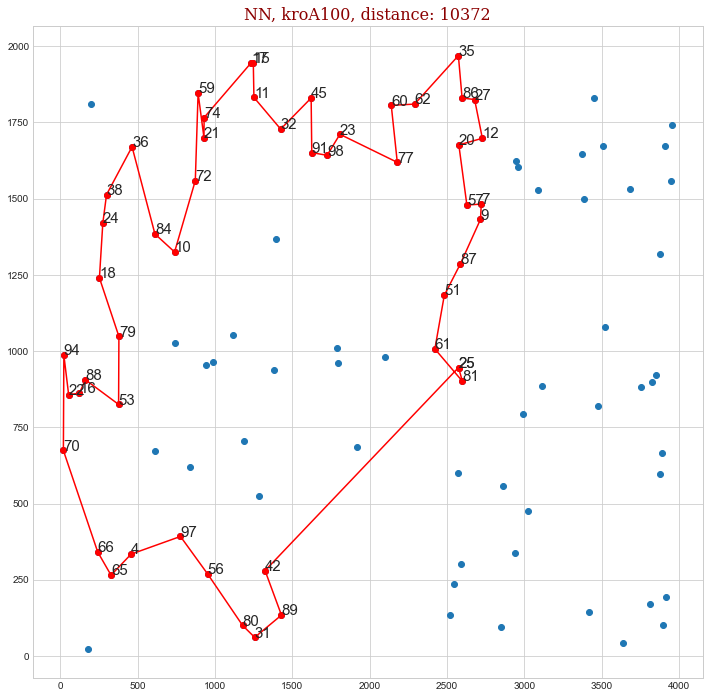

MIN:10372
MAX:14876
AVG:12847.98
Cycle:
['25', '81', '61', '51', '87', '9', '7', '57', '20', '12', '27', '86', '35', '62', '60', '77', '23', '98', '91', '45', '32', '11', '15', '17', '74', '21', '59', '72', '10', '84', '36', '38', '24', '18', '79', '53', '88', '16', '22', '94', '70', '66', '65', '4', '97', '56', '80', '31', '89', '42', '25']


In [150]:
instance  = Instance(NNStrategy())
instance.load_problem("data/kroA100.tsp")
instance.description = "NN, kroA100"
instance.run(50,50)
instance.save_to_file("results/NN_kroA100.png")
instance.show_stats()

#instance  = Instance(NNStrategy())
#instance.run()


#instance.strategy = GreedyCycleStrategy()
#instance.run()

In [135]:
randomlist = random.sample(range(0, 100), 50)


50
50


[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[ 0  0  2  3]
 [ 4  0  6  7]
 [ 8  0 10 11]
 [12  0 14 15]]


In [27]:
def get_tour_distance(self,T):
    s = 0
    for i,t in enumerate(T):
        try:
            s+=self.dis_mat[t][T[i+1]]
        except IndexError:
            s+=self.dis_mat[t][T[0]]
    
    return s
    
class NNStrategy(Strategy):
    def do_algorithm(self, matrix=None, startPoint=1):
        
        """
        Nearest Neighbour algorithm
        """   
        dist_mat = matrix.copy()
        
        
        Tour = [startPoint]
        for _ in  range(100):
            min_index = np.argmin(dist_mat[Tour[-1]])
            for t in Tour:
                dist_mat[min_index,t] = np.inf
                dist_mat[t,min_index] = np.inf
            Tour.append(min_index)
       
        
        return Cycle(np.array(Tour), random.randint(0,1000))
        



















In [308]:
import abc

class Context:
    '''
    Define the interface of interest to clients.
    Maintain a reference to a Strategy object.
    '''
    
    def __init__(self, strategy):
        self._strategy = strategy
        
    def context_interface(self):
        self._strategy.algorithm_interface()
        
class Strategy(metaclass=abc.ABCMeta):
    '''
    Declare an interface common to all supported algorithms. Context
    uses this interface to call the algorithm defined by a
    ConcreteStregy.
    '''
    
    @abc.abstractmethod
    def algorithm_interface(self):
        pass
    
class ConcreteStrategyA(Strategy):
    '''
    Implement the algorithm using the Strategy interface.
    '''
    def algorithm_interface(self):
        pass
    

class ConcreteStrategyB(Strategy):
    '''
    Implement the algorithm using the Strategy interface.
    '''
    def algorithm_interface(self):
        pass
    

def main():
    concrete_strategy_a = ConcreteStrategyA()
    context = Context(concrete_strategy_a)
    context.context_interface()
    
main()

In [130]:
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import List

class Context():
    '''
    The Context defines the interface of interest to clients.
    '''
    
    def __init__(self, strategy: Strategy) -> None:
        '''
        Usually, the Context accepts a strategy through the constructor,
        but also probides a setter to change it at runtime.
        '''
        self._strategy = strategy
        
    @property
    def strategy(self) -> Strategy:
        '''
        The Context maintains a reference to one of the Strategy objects.
        The Context does not know the concrete class of a strategy.
        It should work with all strategies via the Strategy interface.
        '''
        
        return self._strategy
    
    @strategy.setter
    def strategy(self, strategy: Strategy) -> None:
        '''
        Usually, the Context allows replacing a Strategy object at runtime.
        '''
        self._strategy = strategy
        
    def do(self) -> None:
        '''
        The Context delegates some work to the Strategy object instead
        of implementing multiple versions of the algorithm on its own.
        '''
        result = self._strategy.do_algorithm([])
        

class Strategy(ABC):
    '''
    The Strategy interface declares operation common to all supported
    versions of some algorithm.
    
    The Context uses thus interfaces to call the algorithm defined by
    Concrete Strategies.
    '''
    
    @abstractmethod
    def do_algorithm(self, data:List):
        pass
    
'''
Concrete Strategies implement the algorithm wile following the base
Strategy interface. The interface makes them interchangeable in the
Context.
'''

class ConcreteStrategyA(Strategy):
    def do_algorithm(self, data:List) -> List:
        return sorted(data)
    
class ConcreteStrategyB(Strategy):
    def do_algorithm(self, data:List) -> List:
        return reversed(sorted(data))
    
if __name__ == "__main__":
    # The client code picks a concrete strategy and passes it to context.
    # The client should be awaare of the difference between strategies
    # in order to make the right choice.
    
    context = Context(ConcreteStrategyA())
    context.do()
    
    context.strategy = ConcreteStrategyB()
    context.do()
    

In [131]:
import unittest

class TestWithoutDDT(unnittest.TestCase):
    
    def test_without_ddt(self):
        for x in [1, -2, 3, 4, -5]:
            self.assertGreater(x, 0)
            

from ddt import ddt, data, idata, file_data, unpack


@ddt
class TestDDTData(unittest.TestCase):
    
    @data(1, -2, 3, 4, -5)
    def test_with_ddt_data(self, x)
        self.assertGreater(x, 0)
        

def number_generator():
    for x in [1, -2, 3, 4, -5]:
        yield x
        
@ddt
class TestDDTGenerator(unnittest.TestCase):
    @idata(number_generator())
    def test_with_ddt_idata(self, x)
        self.assertGreater(x, 0)
        

SyntaxError: invalid syntax (<ipython-input-131-5603ba5a4260>, line 17)